In [9]:
import numpy as np
import tushare as ts
from plotly import graph_objects as go
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchkeras
from plotly import graph_objects as go
import matplotlib.pyplot as plt

In [10]:
data_close = ts.get_k_data('000001', start='2018-01-01', index=True)['close'].values  # 获取上证指数从20180101开始的收盘价的np.ndarray
data_close = data_close.astype('float32')  # 转换数据类型
# 将价格标准化到0~1
max_value = np.max(data_close)
min_value = np.min(data_close)
data_close = (data_close - min_value) / (max_value - min_value)

print(data_close)

本接口即将停止更新，请尽快使用Pro版接口：https://waditu.com/document/2
[7.06605017e-01 7.23215640e-01 7.36484826e-01 7.41312921e-01
 7.55485475e-01 7.59018540e-01 7.65357554e-01 7.68163323e-01
 7.71040857e-01 7.56292820e-01 7.77156055e-01 7.83614695e-01
 8.07659328e-01 8.18138957e-01 8.28930199e-01 8.65013003e-01
 8.75380576e-01 8.66459846e-01 8.74309361e-01 8.46228182e-01
 8.18258762e-01 8.12519431e-01 7.85461247e-01 7.97531545e-01
 8.17851067e-01 7.24446476e-01 6.75374210e-01 6.37636721e-01
 5.31962156e-01 5.51370323e-01 5.76014459e-01 5.87365270e-01
 6.42840564e-01 6.59195304e-01 6.91609144e-01 6.61633372e-01
 6.35526359e-01 6.46989167e-01 6.31625593e-01 6.33543968e-01
 6.59690797e-01 6.45326436e-01 6.58707619e-01 6.73703492e-01
 6.89314902e-01 6.76157594e-01 6.61081672e-01 6.60866022e-01
 6.43895566e-01 6.51385605e-01 6.60490155e-01 6.52744472e-01
 6.38779759e-01 5.50275266e-01 5.35055578e-01 5.61378241e-01
 5.25919020e-01 5.56486309e-01 5.63176811e-01 5.58604479e-01
 5.37381589e-01 5.32969356e-01 5.

In [11]:
#预览
fig = go.Figure()
fig.add_trace(go.Scatter(y=data_close))
fig.show()

In [12]:
DAYS_FOR_TRAIN = 10
def create_dataset(data, days_for_train=5) -> (np.array, np.array):
    """
        根据给定的序列data，生成数据集

        数据集分为输入和输出，每一个输入的长度为days_for_train，每一个输出的长度为1。
        也就是说用days_for_train天的数据，对应下一天的数据。
        若给定序列的长度为d，将输出长度为(d-days_for_train+1)个输入/输出对
    """
    dataset_x, dataset_y= [], []
    for i in range(len(data)-days_for_train):
        _x = data[i:(i+days_for_train)]
        dataset_x.append(_x)
        dataset_y.append(data[i+days_for_train])
    return (np.array(dataset_x), np.array(dataset_y))
dataset_x, dataset_y = create_dataset(data_close, DAYS_FOR_TRAIN)
# 划分训练集和测试集，70%作为训练集
train_size = int(len(dataset_x) * 0.7)
train_x = dataset_x[:train_size]
train_y = dataset_y[:train_size]
# 将数据改变形状，RNN 读入的数据维度是 (seq_size, batch_size, feature_size)
train_x = train_x.reshape(-1, 1, DAYS_FOR_TRAIN)
train_y = train_y.reshape(-1, 1, 1)
# 转为pytorch的tensor对象
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)


In [13]:
import torch
from torch import nn
class LSTM_Regression(nn.Module):
    """
        使用LSTM进行回归

        参数：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, _x):
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s*b, h)
        x = self.fc(x)
        x = x.view(s, b, -1)  # 把形状改回来
        return x
model = LSTM_Regression(DAYS_FOR_TRAIN, 8, output_size=1, num_layers=2)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


In [14]:
for i in range(1000):
    out = model(train_x)
    loss = loss_function(out, train_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (i+1) % 100 == 0:
        print('Epoch: {}, Loss:{:.5f}'.format(i+1, loss.item()))


Epoch: 100, Loss:0.00134
Epoch: 200, Loss:0.00094
Epoch: 300, Loss:0.00086
Epoch: 400, Loss:0.00085
Epoch: 500, Loss:0.00086
Epoch: 600, Loss:0.00085
Epoch: 700, Loss:0.00084
Epoch: 800, Loss:0.00084
Epoch: 900, Loss:0.00084
Epoch: 1000, Loss:0.00083


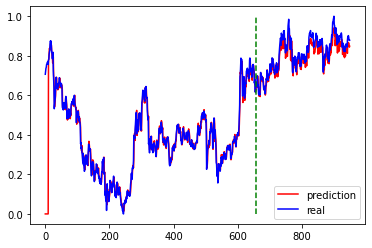

In [15]:
import matplotlib.pyplot as plt
model = model.eval() # 转换成测试模式
# 注意这里用的是全集 模型的输出长度会比原数据少DAYS_FOR_TRAIN 填充使长度相等再作图
dataset_x = dataset_x.reshape(-1, 1, DAYS_FOR_TRAIN)  # (seq_size, batch_size, feature_size)
dataset_x = torch.from_numpy(dataset_x)
pred_test = model(dataset_x) # 全量训练集的模型输出 (seq_size, batch_size, output_size)
pred_test = pred_test.view(-1).data.numpy()
pred_test = np.concatenate((np.zeros(DAYS_FOR_TRAIN), pred_test))  # 填充0 使长度相同
assert len(pred_test) == len(data_close)
plt.plot(pred_test, 'r', label='prediction')
plt.plot(data_close, 'b', label='real')
plt.plot((train_size, train_size), (0, 1), 'g--')
plt.legend(loc='best')
plt.show()
